<ipython-input-8-e94480ed69df>:57: RuntimeWarning: invalid value encountered in sqrt
  v[:, i] = v[:, i-1] + kappa * (vbar - v[:, i-1]) * dt + xi * np.sqrt(v[:, i-1]) * dw2[:, i-1]
<ipython-input-8-e94480ed69df>:59: RuntimeWarning: invalid value encountered in sqrt
  s = s0 * np.exp(np.cumsum(np.pad(rate * dt + np.sqrt(v[:, :-1]) * dw1 + (jmean + jvol * z) * dj, ((0, 0), (1, 0))), axis=1))


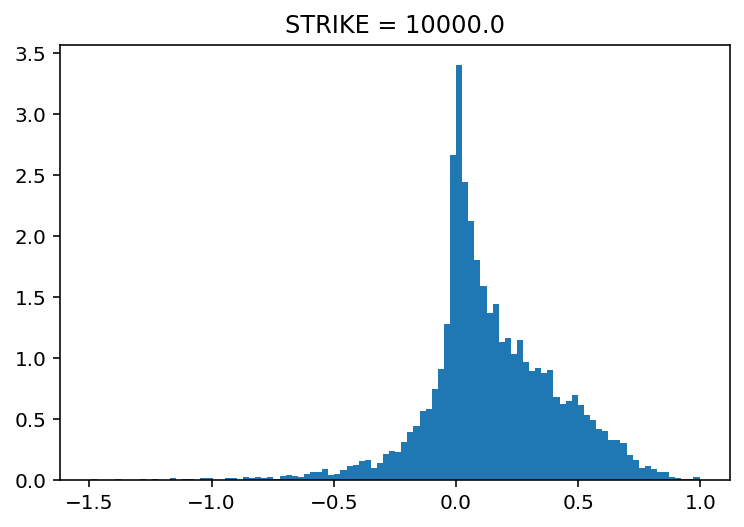

In [8]:
from qfin.utils import bs_explicit_call, bs_call_delta
import numpy as np
import matplotlib.pyplot as plt

# seed
np.random.seed(1337)

# model parameters
v0 = 10.
vbar = 1.
xi = 3.
lambdah = 1.
kappa = 1.
rho = 0.
jmean = -0.07
jvol = 0.6

# market parameters
maturity = 1.
strike = 10000.
s0 = 10000.
rate = 0.

# implementation parameters
steps = 365
dt = 1/steps
npaths = 10000


def integrate(v0, path, strategy, rate=0., dt=1/365):

    pnl = v0 - strategy[:, :, 0] * path[:, :, 0]
    steps = strategy.shape[2] - 1
    
    for i in range(1, steps):
        pnl = np.exp(rate * dt) * pnl - (strategy[:, :, i] - strategy[:, :, i - 1]) * path[:, :, i]

    pnl *= np.exp(rate * dt)
    pnl += (strategy[:, :, steps - 1]) * path[:, :, steps]
        
    return pnl


def bs(steps=100, dt=1/365, s0=1., rate=0., npaths=1):
    
    # randomness
    dw1 = np.sqrt(dt) * np.random.standard_normal((npaths, steps - 1))
    dw2 = np.sqrt(1 - rho ** 2) * np.sqrt(dt) * np.random.standard_normal((npaths, steps - 1)) + rho * dw1
    dj = np.random.binomial(1, lambdah * dt, size=(npaths, steps - 1))
    z = np.random.standard_normal(size=(npaths, steps - 1))

    # variance
    v = np.zeros((npaths, steps))
    v[:, 0] = v0

    for i in range(1, steps):
        v[:, i] = v[:, i-1] + kappa * (vbar - v[:, i-1]) * dt + xi * np.sqrt(v[:, i-1]) * dw2[:, i-1]
        
    s = s0 * np.exp(np.cumsum(np.pad(rate * dt + np.sqrt(v[:, :-1]) * dw1 + (jmean + jvol * z) * dj, ((0, 0), (1, 0))), axis=1))

    return s


path = np.array([bs(steps=steps, dt=dt, npaths=npaths, s0=s0)])

ttm = np.linspace(maturity, 0, steps)
delta = bs_call_delta(ttm, strike, path, rate, np.sqrt(v0))
price = bs_explicit_call(maturity, strike, s0, rate, np.sqrt(v0))

# calculate pnl
pnl = integrate(price, path, delta, rate, dt)
pnl -= np.maximum(path[0, :, -1] - strike, 0)

fig, ax = plt.subplots()
ax.set_title(f"STRIKE = {strike}")
_ = ax.hist(pnl.reshape(-1) / price, density=True, bins=100)
